# Wikidata Knowledge Graph Extraction
DKN, RippleNet, KGCN 같은 많은 추천 알고리즘은 정보의 외부 소스로 지식 그래프를 사용한다. 이 노트에서 앞에 언급된 알고리즘에 사용될 수있는 KG를 추출하기 위해 Wikipedia 쿼리와 Wikidata를 어떻게 다룰 수 있는지 소개한다.
- 텍스트 쿼리에서 Wikidata entity를 찾는 법
- entity에 대한 설명과 주변 entity들을 찾는 법
- Movielens에 대한 KG 만들기

In [1]:
import sys
import papermill as pm
import scrapbook as sb
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from recommenders.datasets import movielens
from recommenders.datasets.wikidata import search_wikidata, find_wikidata_id, query_entity_links, query_entity_description, read_linked_entities

## 1. Create a KG from linked entities in Wikidata
아래의 코드는 `search_wikidata()` 도우미 함수로 랩핑되었다. It is provided here to show the details of which calls are being made to wikipedia APIs.

In [2]:
names = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]

In [3]:
%%time
results_list = []
for idx, name in enumerate(names):
    entity_id = find_wikidata_id(name)
    if entity_id == 'entityNotFound':
        continue
        
    json_links = query_entity_links(entity_id) # get entity links
    related_links = read_linked_entities(json_links) # extracts entities from the links
    
    # construct an connection between two entities
    for related_entity, related_name in related_links:
        result = dict(name=name, original_entity=entity_id, linked_entities=related_entity,
                     name_linked_entities=related_name)
        results_list.append(result)

results_list = pd.DataFrame(results_list)
results_list.head()

ENTITY NOT FOUND


CPU times: user 169 ms, sys: 12.5 ms, total: 182 ms
Wall time: 15.9 s


,name,original_entity,linked_entities,name_linked_entities
0,The Godfather,Q47703,Q377616,New Hollywood
1,The Godfather,Q47703,Q130232,drama film
2,The Godfather,Q47703,Q52207399,film based on a novel
3,The Godfather,Q47703,Q7444356,gangster film
4,The Godfather,Q47703,Q959790,crime film


## Visualize KG using network

In [4]:
G = nx.from_pandas_edgelist(results_list, 'original_entity', 'linked_entities')

target_names = results_list[['linked_entities', 'name_linked_entities']].drop_duplicates().rename(columns={'linked_entities':'labels', 'name_linked_entities':'name'})
source_names = results_list[['original_entity', 'name']].drop_duplicates().rename(columns={'original_entity':'labels'})
names = pd.concat([target_names, source_names])
names = names.set_index('labels')
names = names.to_dict()['name']

In [5]:
names

{'Q377616': 'New Hollywood',
 'Q130232': 'drama film',
 'Q52207399': 'film based on a novel',
 'Q7444356': 'gangster film',
 'Q959790': 'crime film',
 'Q243556': 'The Godfather',
 'Q184768': 'The Godfather Part II',
 'Q102642': 'Diane Keaton',
 'Q10390375': 'Victor Rendina',
 'Q108622': 'Talia Shire',
 'Q1147417': 'Simonetta Stefanelli',
 'Q1352034': 'Lenny Montana',
 'Q1622732': 'Gianni Russo',
 'Q16575211': 'Tony King',
 'Q16745067': 'Tony Giorgio',
 'Q171736': 'Robert Duvall',
 'Q193628': 'Sofia Coppola',
 'Q19956031': 'Ron Gilbert',
 'Q2300160': 'Vito Scotti',
 'Q245808': 'Roman Coppola',
 'Q29585307': 'Nick Vallelonga',
 'Q296177': 'John Cazale',
 'Q318220': 'Abe Vigoda',
 'Q323166': 'Sterling Hayden',
 'Q3694232': 'Corrado Gaipa',
 'Q376261': 'Angelo Infanti',
 'Q380872': 'Al Martino',
 'Q3809461': 'Johnny Martino',
 'Q3811107': 'Julie Gregg',
 'Q464714': 'Richard S. Castellano',
 'Q524930': 'Morgana King',
 'Q554430': 'Franco Citti',
 'Q558492': 'Al Lettieri',
 'Q56333356': 'Sal

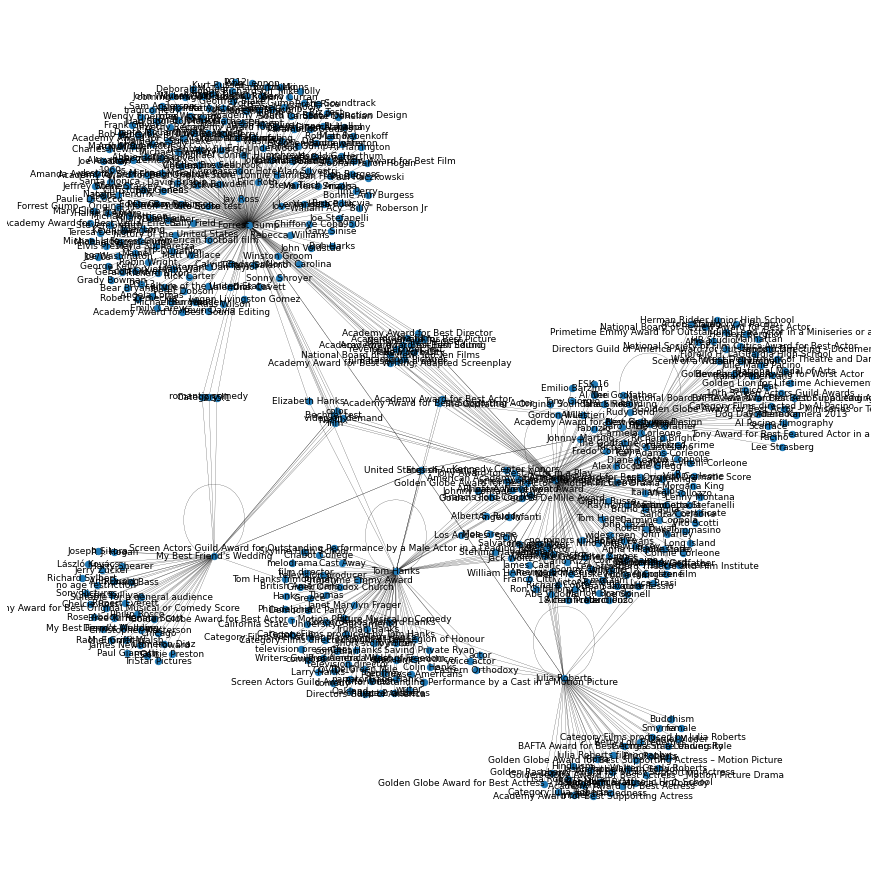

In [6]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=40, font_size=9, width=0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

## Create a KG from the Movielens Dataset

In [7]:
df = movielens.load_pandas_df('100k', ('UserId', 'ItemId', 'Rating', 'Timestamp'),
                             title_col='Title', genres_col='Genres', year_col='Year')
movies = df[['Title', 'ItemId']].drop_duplicates().reset_index()
movies['Title'][:5]

100%|█████████████████████████████████████| 4.81k/4.81k [00:02<00:00, 2.03kKB/s]


0                  Kolya (1996)
1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [8]:
movies = movies.head(50)

In [9]:
names = [t + ' film' for t in movies['Title']]
result = search_wikidata(names, extras=movies[['Title', 'ItemId']].to_dict())
result.head()

DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND
DESCRIPTION NOT FOUND


,name,original_entity,linked_entities,name_linked_entities,description,Title,ItemId
0,Kolya (1996) film,Q1141186,Q130232,drama film,1996 film by Jan Svěrák,Kolya (1996),242
1,Kolya (1996) film,Q1141186,Q157443,comedy film,1996 film by Jan Svěrák,Kolya (1996),242
2,Kolya (1996) film,Q1141186,Q100977416,Věra Uzelacová,1996 film by Jan Svěrák,Kolya (1996),242
3,Kolya (1996) film,Q1141186,Q104626218,Luboš Bíža,1996 film by Jan Svěrák,Kolya (1996),242
4,Kolya (1996) film,Q1141186,Q10819887,Andrei Chalimon,1996 film by Jan Svěrák,Kolya (1996),242


In [10]:
result['Title'].value_counts()

Aladdin (1992)                                                                 258
Right Stuff, The (1983)                                                        134
Silence of the Lambs, The (1991)                                                99
Men in Black (1997)                                                             96
Kolya (1996)                                                                    95
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)     95
Hunt for Red October, The (1990)                                                95
Toy Story (1995)                                                                86
Sting, The (1973)                                                               84
Die Hard (1988)                                                                 84
Star Trek: First Contact (1996)                                                 82
Age of Innocence, The (1993)                                                    81
L.A.

In [11]:
# result.to_csv("movielens_" + MOVIELENS_DATA_SIZE + '_wikidata.csv', index = False)
number_movies = len(result['Title'].unique())
# Record results with papermill for unit-tests
sb.glue("length_result", number_movies)